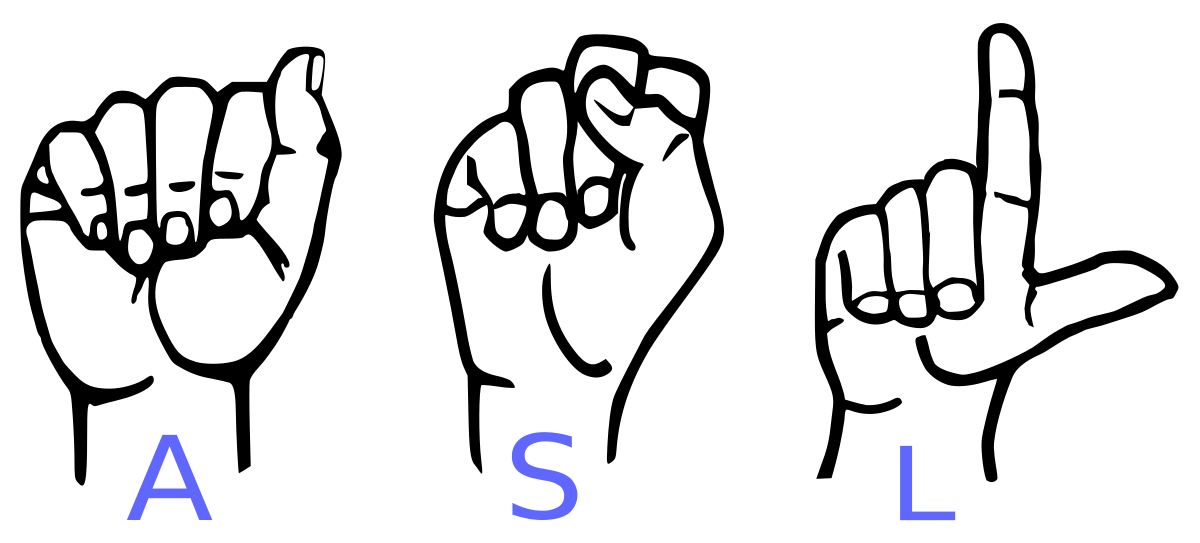

## Objective ⚒
In this notebook, we will interpret ASL images using TensorFlow. Things we will cover:
<h4>1. Create the train and test data
<h4>2. Determine training and network parameters
<h4>3. Construct the neural network
<h4>4. Define our loss function and SGD Optimizer
<h4>5. Train the neural network 
<h4>6. Validate the model
<h4>7. Results</h4>
<p>I will also be giving my insight every step of the way! Let's dive in!</p>

## What is TensorFlow? 
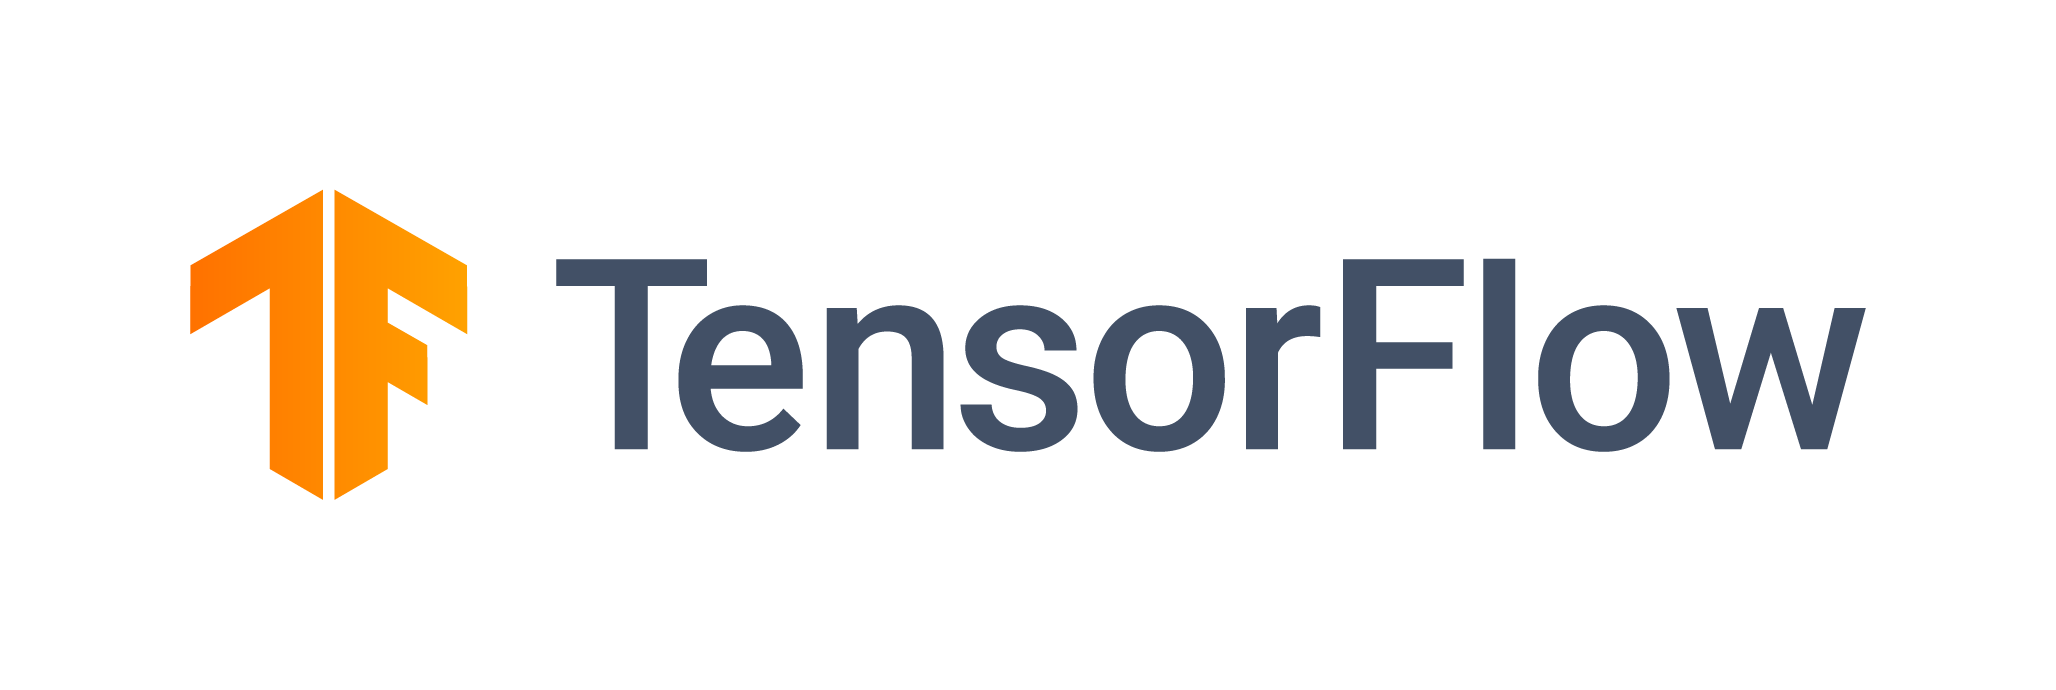
<li>Before we get into the programming bit, let us establish what <b>TensorFlow</b> is -  It is a Python library that allows you to create neural networks with many layers. It is free and open source and was developed by Google.
<li>Although there are neural networks that are specifically well suited for image recognition, we actually don't need to go there for this relatively simple task.
<li>There are libraries like Keras and TFLearn that run on top of TensorFlow.These are higher level API's to TensorFlow
  but for this dataset, we can do without any of these libraries. 
    
 


In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Create the train and test data
>    <h4>📝 COMMENTS</h4>
>    Before we can work on the data, let's start off by importing the necessary libraries.
>    <li> <b>cv2</b> - We use cv2 to load image from a specified file and also resize it to the desired pixel size
>    <li> <b>tensorflow</b> - This library will help us construct and train a neural network that will do the classification for us
>    <li> <b>tqdm</b> - a smart progress meter
>    <li> The training set contains 87,000 images which are 200x200 pixels.There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.
>    <li> While reading the images, I have resized it to 50x 50 pixels. The labels_map dictionary maps each of the 29 classes to a corresponding number


In [10]:
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import numpy as np

train_dir = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/"
test_dir =  "../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
IMG_SIZE = 50
labels_map = {'A':0,'B':1,'C': 2, 'D': 3, 'E':4,'F':5,'G':6, 'H': 7, 'I':8, 'J':9,'K':10,'L':11, 'M': 12, 'N': 13, 'O':14, 
                'P':15,'Q':16, 'R': 17, 'S': 18, 'T':19, 'U':20,'V':21, 'W': 22, 'X': 23, 'Y':24, 'Z':25, 
                'del': 26, 'nothing': 27,'space':28}

In [11]:
def create_train_data():
    x_train = []
    y_train = []
    for folder_name in os.listdir(train_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(train_dir + folder_name)):
            path = os.path.join(train_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE ))
            x_train.append(np.array(img))
            y_train.append(np.array(label))
    print("Done creating train data")
    return x_train, y_train


In [12]:
def create_test_data():
    x_test = []
    y_test = []
    for folder_name in os.listdir(test_dir):
        label = folder_name.replace("_test.jpg","")
        label = labels_map[label]
        path = os.path.join(test_dir,folder_name)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE ))
        x_test.append(np.array(img))
        y_test.append(np.array(label))
    print("Done creating test data")
    return x_test,y_test

In [13]:
x_train, y_train= create_train_data()  
x_test,y_test = create_test_data()

100%|██████████| 3000/3000 [00:08<00:00, 372.78it/s]


Done creating train data
Done creating test data


>    <h4>📝 COMMENTS</h4>
>  <li> The number of features are 25000 [50 x50 pixels] i.e considering each pixel as a feature for the image.We reshape the images into 1D arrays of 2500 pixels. Each one of those values will be an input node into our deep neural network. We also normalize the inputs to be a value between 0 and 1 (inclusive)
> <li>The number of class are 29, which means there will be 29 neurons in the output layer each representing an output class A-Z, SPACE, NOTHING or DELETE 

In [14]:
num_features = 2500
num_classes = 29

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

>   <h4>📝 COMMENTS</h4>
>   <li>The training images are therefore a tensor of shape [87,000, 25000]. The training labels are a one-dimensional tensor of 87,000 labels that range from 0 to 28.
>   <li>  Let's get a feel of what the images look like compressed to 50 x 50 pixels and in gray scale. Remember we have compressed it from 200 x 200 to 50 x 50. Looking at the image below it is a bit pixellated; but still looks good!  

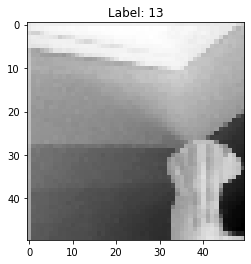

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_image(num):
    label = y_train[num]
    plt.title('Label: %d' % (label))
    image = x_train[num].reshape([IMG_SIZE,IMG_SIZE])
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
display_image(5)

## Determining training and network parameters
 >   <h4>📝 COMMENTS</h4>
 > <li>These parameters or "hyperparameters" are ones we have to experiment with to improve upon the <b>accuracy</b> of the neural network. A little tweak could result in a huge difference!
    >  <li> <b>learning rate</b> - controls how much to change the model in response to the estimated error each time the model weights are updated. 
    >  <li> <b> training steps</b> - number of epochs
    >  <li> <b> batch size</b> - small chunks for each iteration of training
    >  <li><b> n hidden</b> - number of neurons in the hidden layer
 >  <li> We use tf.data API to shuffle the data and divide it into batches


In [16]:
# Training parameters.
learning_rate = 0.001
training_steps = 5000
batch_size = 250
display_step = 500

# Network parameters.
n_hidden =  300# Number of neurons.

In [17]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(87000).batch(batch_size).prefetch(1)

## Constructing the neural network
>   <h4>📝 COMMENTS</h4>
>   <li>We start by initializing weights randomly for each layer in the neural network. We use the RandomNormal API to do so.
>   <li> We can use bias to allow the activation function to be shifted to the left or right, to better fit the data. Bias makes it easier for the neural networks to fire. The biases are initialized to zero and are learnt during training.
>   <li> The neural network consist of 2 hidden layers, with 300 neurons in each layer and one output layer followed by a <b>softmax</b> function that converts the weights of the neural network into probabilities for each class. Softmax helps turn the weights into probabilities and make it a classification problem.

In [18]:
# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden])),
    'h2': tf.Variable(random_normal([n_hidden, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [19]:
def neural_nets(input_data):
    hidden_layer1 = tf.add(tf.matmul(input_data,weights['h1']),biases['b'])
    hidden_layer1 = tf.nn.sigmoid(hidden_layer1)
    
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1,weights['h2']),biases['b'])
    hidden_layer2 = tf.nn.sigmoid(hidden_layer2)
    
    out_layer = tf.add(tf.matmul(hidden_layer1,weights['out']),biases['out'])
    
    return tf.nn.softmax(out_layer)

## Defining our loss function and SGD Optimizer
>   <h4>📝 COMMENTS</h4>
>    <li>The loss function for measuring the progress in gradient descent: <b>cross entropy</b>. It uses a logrithamic scale that penalizes incorrect classification more than the ones that are close.
>    <li> Finally we set up the <b>stocashtic gradient descent optimizer</b>. The gradient tape is a TensorFlow API that does <b>reverse mode auto differentiation</b>. It's the new way of setting up neural nets from scratch in Tensorflow 2.
>   <li> We define a function to measure the accuracy of the neural network. It does this by selecting the class with the highest probability and matching it to the true class.


In [20]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_nets(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [22]:
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    #print("argmax:",tf.argmax(y_pred,1))
    #print("cast",tf.cast(y_true, tf.int64))
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

## Training the neural network 
>   <h4>📝 COMMENTS</h4>
    > <li> Now that we have everything set up, let's try to run it!
    > <li> We train the model in 4000 epochs or training steps. At each step we run the optimization function on a small chunk of training data 250 records, in our case
    > <li> Every 100 steps we display the current <b>Loss function and Accuracy</b> of the model

In [29]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_nets(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 500, Loss: 120.490433, Accuracy: 0.872000
Training epoch: 1000, Loss: 60.460381, Accuracy: 0.948000
Training epoch: 1500, Loss: 58.080177, Accuracy: 0.968000
Training epoch: 2000, Loss: 52.185989, Accuracy: 0.984000
Training epoch: 2500, Loss: 55.517048, Accuracy: 0.968000
Training epoch: 3000, Loss: 89.920959, Accuracy: 0.912000
Training epoch: 3500, Loss: 58.268372, Accuracy: 0.968000
Training epoch: 4000, Loss: 107.255249, Accuracy: 0.872000
Training epoch: 4500, Loss: 48.516014, Accuracy: 0.960000
Training epoch: 5000, Loss: 52.172318, Accuracy: 0.960000


## Validating the model

In [30]:
# Test model on validation set.
pred = neural_nets(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 1.000000


> <h4> 📊 My insight</h4>
> <li>The highest accuracy I have got is <b>1.0</b> meaning all the images have been correctly classified in the test set.
This might change each time we train the model because each time we start with different random weights and biases.
> <li> We can tweak the hyperparameters and the layers and neurons in the network to try out different topologies to see if they give better results.


In [31]:
def get_key(val):
    for key, value in labels_map.items(): 
         if val == value: 
            return key 

## Results

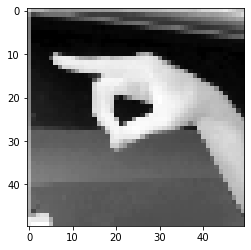

Original Labels: P
Model prediction: P


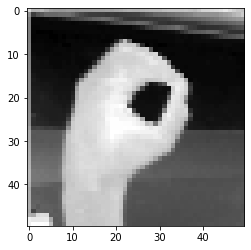

Original Labels: O
Model prediction: O


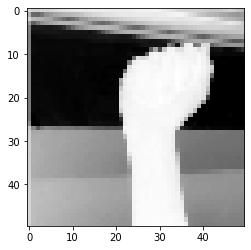

Original Labels: A
Model prediction: A


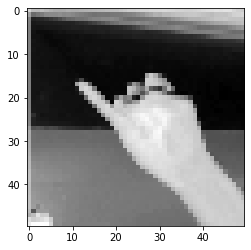

Original Labels: J
Model prediction: J


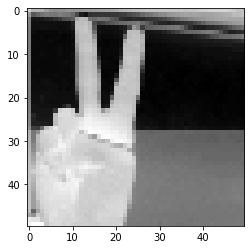

Original Labels: V
Model prediction: V


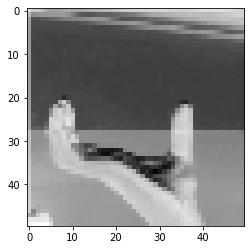

Original Labels: space
Model prediction: space


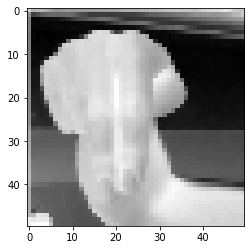

Original Labels: N
Model prediction: N


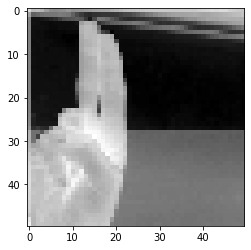

Original Labels: U
Model prediction: U


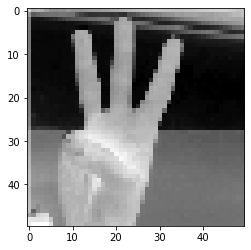

Original Labels: W
Model prediction: W


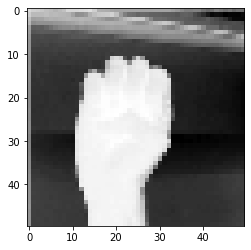

Original Labels: E
Model prediction: E


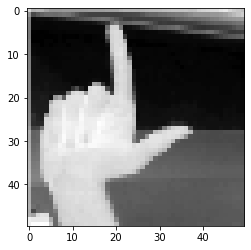

Original Labels: L
Model prediction: L


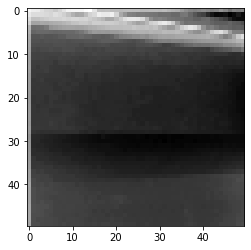

Original Labels: nothing
Model prediction: nothing


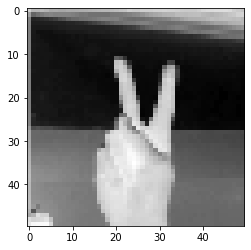

Original Labels: K
Model prediction: K


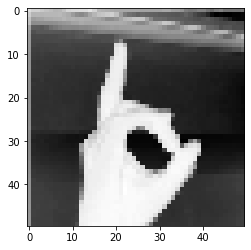

Original Labels: D
Model prediction: D


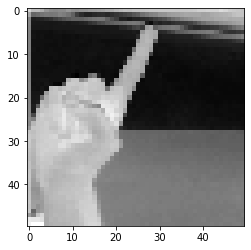

Original Labels: Z
Model prediction: Z


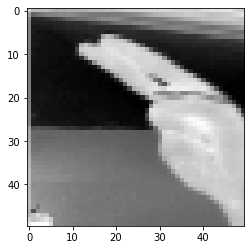

Original Labels: H
Model prediction: H


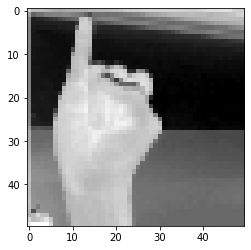

Original Labels: I
Model prediction: I


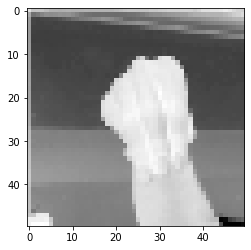

Original Labels: M
Model prediction: M


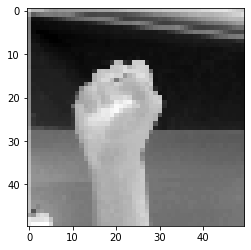

Original Labels: S
Model prediction: S


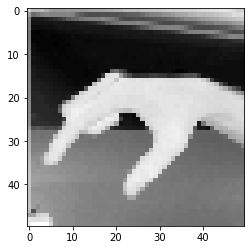

Original Labels: Q
Model prediction: Q


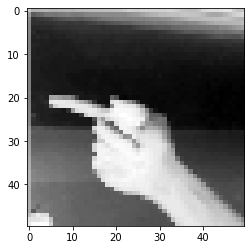

Original Labels: G
Model prediction: G


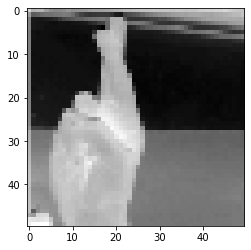

Original Labels: R
Model prediction: R


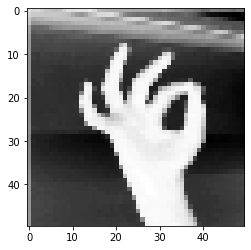

Original Labels: F
Model prediction: F


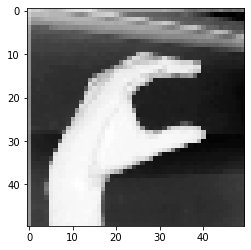

Original Labels: C
Model prediction: C


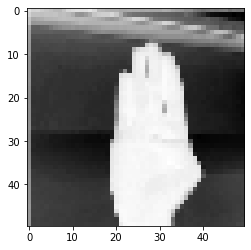

Original Labels: B
Model prediction: B


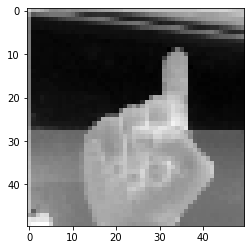

Original Labels: X
Model prediction: X


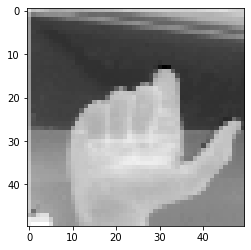

Original Labels: T
Model prediction: T


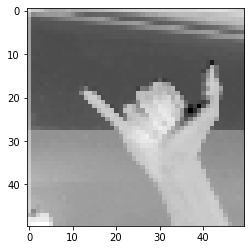

Original Labels: Y
Model prediction: Y


In [32]:
n_images = 28
predictions = neural_nets(x_test)
for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    plt.imshow(np.reshape(x_test[i], [50, 50]), cmap='gray_r')
    plt.show()
    print("Original Labels: %s" % get_key(y_test[i]))
    print("Model prediction: %s" % get_key(model_prediction))

> <h4>📊My insight</h4>
    ><li>Let's take a look at some of the test images and see just how good or bad our model is, compared to what your own brain can do. 
    ><li> Our model has done excellent job in classifying the images to the right classes. And we are very happy with this simple neural network for now, it seems to do it's job. In future notebooks, we will dive deeper into more sofisticated neural networks for harder problems. We will also make use of the in-built API's Python provides like Keras and TFLearn. </li>

Don't forget to <b>upvote</b> if you found this notebook insightful!</p>